## Bitcoin Analysis and Visualization with Plotly, Price Prediction with LSTM model

\* In order to see fully rendered visualizations by Plotly in jupyter notebook, please visit [this link](https://nbviewer.jupyter.org/github/AsunaMasuda/Bitcoin_plotly_keras/tree/master/Bitcoin%20Analysis%20and%20Visualization%20with%20Plotly,%20Price%20Prediction%20with%20Keras.ipynb) on jupyter nbviewer. (ipython files in Github repository cannot show visualizations by plotly.)

### Overview of this notebook
This notebook focuses on these two purposes below, mainly for the writer's self-learning purpose:

- Data clearning and analysis with Python libraries and Bitcoin price prediction by deep learning algolism called LSTM with Keras
- Interactive Data visualizations with Plotly

To create this notebook, 
<br>For data visualization with Plotly:
<br>I refered to [a Kaggle post](https://www.kaggle.com/kanncaa1/plotly-tutorial-for-beginners) by [DATAI](https://www.kaggle.com/kanncaa1) and Plotly [official document](https://plot.ly/python/).
<br>For price prediction with LSTM by Keras:
<br>I refered to [a jupyter notebook](https://github.com/dashee87/blogScripts/blob/master/Jupyter/2017-11-20-predicting-cryptocurrency-prices-with-deep-learning.ipynb) which explained an applicaiton of deep learning to Bitcoin/Etherium price prediction by a data scientist [David Sheeran](https://dashee87.github.io/about/).

<p><img src="bit_image.jpg" style="width:500px"></p>

### Context

Bitcoin is the longest running and most well known cryptocurrency, first released as open source in 2009 by the anonymous Satoshi Nakamoto. Bitcoin serves as a decentralized medium of digital exchange, with transactions verified and recorded in a public distributed ledger (the blockchain) without the need for a trusted record keeping authority or central intermediary. Transaction blocks contain a SHA-256 cryptographic hash of previous transaction blocks, and are thus "chained" together, serving as an immutable record of all transactions that have ever occurred. As with any currency/commodity on the market, bitcoin trading and financial instruments soon followed public adoption of bitcoin and continue to grow. Included here is historical bitcoin market data at 1-min intervals for select bitcoin exchanges where trading takes place.

### Datasets
- coinbaseUSD_1-min_data_2014-12-01_to_2019-01-09.csv
- bitstampUSD_1-min_data_2012-01-01_to_2019-08-12.csv

CSV files for select bitcoin exchanges for the time period of Jan 2012 to August 2019, with minute to minute updates of OHLC (Open, High, Low, Close), Volume in BTC and indicated currency, and weighted bitcoin price. Timestamps are in Unix time. Timestamps without any trades or activity have their data fields filled with NaNs. If a timestamp is missing, or if there are jumps, this may be because the exchange (or its API) was down, the exchange (or its API) did not exist, or some other unforseen technical error in data reporting or gathering. All effort has been made to deduplicate entries and verify the contents are correct and complete to the best of my ability, but obviously trust at your own risk.

Explanation of the columns:
- Timestamp: Start time of time window (60s window), in Unix time
- OpenOpen: price at start time window
- High: High price within time window
- Low: Low price within time window
- Close: Close price at end of time window
- Volume_(BTC): Amount of BTC transacted in time window
- Volume_(Currency): Amount of Currency transacted in time window
- Weighted_Price: Volume-Weighted Average Price price (VWAP)

In [1]:
# import libraries
import time
start_time=time.time()
import numpy as np
from collections import Counter
import pandas as pd
import matplotlib.pyplot as plt
from plotly import __version__
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
import plotly as py
import plotly.graph_objs as go
init_notebook_mode(connected=True)
plt.rcParams['figure.figsize']=(12,5)
import numpy as np
import operator
import pandas as pd

# not to show warning messages
import warnings
warnings.filterwarnings('ignore')

In [2]:
# read csv files
df_bitstamp = pd.read_csv('bitstampUSD_1-min_data_2012-01-01_to_2019-08-12.csv')
df_coinbase = pd.read_csv('coinbaseUSD_1-min_data_2014-12-01_to_2019-01-09.csv')

In [3]:
df_bitstamp.head()

,Timestamp,Open,High,Low,Close,Volume_(BTC),Volume_(Currency),Weighted_Price
0,1325317920,4.39,4.39,4.39,4.39,0.455581,2.0,4.39
1,1325317980,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,1325318040,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,1325318100,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,1325318160,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [4]:
df_bitstamp.shape

(3997697, 8)

In [5]:
df_coinbase.head()

,Timestamp,Open,High,Low,Close,Volume_(BTC),Volume_(Currency),Weighted_Price
0,1417411980,300.0,300.0,300.0,300.0,0.01,3.0,300.0
1,1417412040,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,1417412100,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,1417412160,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,1417412220,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [6]:
df_coinbase.shape

(2099760, 8)

In [7]:
# Convert Timestamp from unix 1 
df_bitstamp = pd.concat([df_bitstamp.drop('Timestamp', axis=1),
                         pd.DataFrame(pd.to_datetime(df_bitstamp['Timestamp'], unit='s'))], axis=1)

In [8]:
df_bitstamp.index = df_bitstamp.Timestamp

In [9]:
# Convert Timestamp from unix 2
df_coinbase = pd.concat([df_coinbase.drop('Timestamp', axis=1), 
                         pd.DataFrame(pd.to_datetime(df_coinbase['Timestamp'], unit='s'))], axis=1)

In [10]:
df_coinbase.index = df_coinbase.Timestamp

### Check the number of null

In [11]:
# Create dataframes that hold missing values
bitstamp_missing = df_bitstamp.isnull().mean()*100
coinbase_missing = df_coinbase.isnull().mean()*100

In [12]:
# import graph objects as "go"
import plotly.graph_objs as go
from plotly import subplots

# Draw graphes
trace0 = go.Bar(x = bitstamp_missing.index,
               y = bitstamp_missing,
               marker = dict(color = 'rgba(245, 140, 130, 0.5)',
               line=dict(color='rgb(0,0,0)',width=1.5)))

trace1 = go.Bar(x = coinbase_missing.index,
               y = coinbase_missing,
               marker = dict(color = 'rgba(130, 135, 245, 0.5)',
               line=dict(color='rgb(0,0,0)',width=1.5)))

fig = subplots.make_subplots(rows=1, cols=2,subplot_titles=("bitstamp dataframe","coinbase dataframe"))

fig.append_trace(trace0, 1, 1)
fig.append_trace(trace1, 1, 2)

fig['layout'].update(height=400, width=800, title='Null Percentages')
iplot(fig);

It seems columns except Timestamp missing values at the same rows.

In [13]:
# Since the timestamp is not empty, we fill missing value with ffill method
df_bitstamp['Open'].fillna(method='ffill', inplace=True)
df_bitstamp['High'].fillna(method='ffill', inplace=True)
df_bitstamp['Low'].fillna(method='ffill', inplace=True)
df_bitstamp['Close'].fillna(method='ffill', inplace=True)
df_bitstamp['Volume_(BTC)'].fillna(method='ffill', inplace=True)
df_bitstamp['Volume_(Currency)'].fillna(method='ffill', inplace=True)
df_bitstamp['Weighted_Price'].fillna(method='ffill', inplace=True)

df_coinbase['Open'].fillna(method='ffill', inplace=True)
df_coinbase['High'].fillna(method='ffill', inplace=True)
df_coinbase['Low'].fillna(method='ffill', inplace=True)
df_coinbase['Close'].fillna(method='ffill', inplace=True)
df_coinbase['Volume_(BTC)'].fillna(method='ffill', inplace=True)
df_coinbase['Volume_(Currency)'].fillna(method='ffill', inplace=True)
df_coinbase['Weighted_Price'].fillna(method='ffill', inplace=True)

### Price change with timeseries

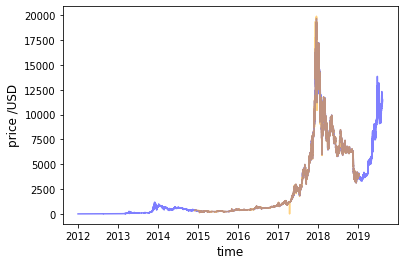

In [14]:
# draw
plt.plot(df_bitstamp.index, df_bitstamp.Weighted_Price, alpha=0.5, color='blue')
plt.plot(df_coinbase.index, df_coinbase.Weighted_Price, alpha=0.5, color='orange')
plt.xlabel('time', fontsize=12)
plt.ylabel('price /USD', fontsize=12);

- coinbase data is missing during before 2015 and after 2019
- There was a peak in price between late 2017 and middle of 2018

bitstamp data seems to have more comprehensive data, so I'll be using only bitstamp data for further analysis

### More insights on bitstamp data

In [15]:
# change timeseries to monthly and weekly
df_bitstamp_m = df_bitstamp.resample('M').mean()
df_bitstamp_w = df_bitstamp.resample('W').mean()

In [16]:
trace_week = go.Scatter(x = df_bitstamp_w.index,
                   y = df_bitstamp_w.Weighted_Price,
                   mode = "lines",
                   name = "Weekly",
                   marker = dict(color = 'rgba(235, 115, 150, 0.8)')
                       )
trace_month = go.Scatter(x = df_bitstamp_m.index,
                   y = df_bitstamp_m.Weighted_Price,
                   mode = "lines",
                   name = "Monthly",
                   marker = dict(color = 'rgba(115, 120, 235, 0.8)')
                       )

data_2 = [trace_week, trace_month]


updatemenus = list([
    dict(active=-1,
         buttons=list([
            dict(label = 'Weekly',
                 method = 'update',
                 args = [{'visible': [True, False]}
                         ]),
            dict(label = 'Monthly',
                 method = 'update',
                 args = [{'visible': [False, True]}
                         ]),
            dict(label = 'Reset',
                 method = 'update',
                 args = [{'visible': [True, True]}])
         ]),
         x = 1.3, y = 1),
])

layout_2 = go.Layout(height=400, width=550, showlegend=False,
                title='Weekly/Monthly Volume-Weighted Average Price', 
                xaxis_title="timestamp",
                yaxis_title="VWAP /USD",
                updatemenus=updatemenus)

fig = dict(data = data_2, layout = layout_2)
iplot(fig);

In [17]:
# Other data
trace_btc = go.Scatter(x = df_bitstamp_m.index,
                   y = df_bitstamp_w['Volume_(BTC)'],
                   mode = "lines",
                   name = "Volume_(BTC)",
                   marker = dict(color = 'rgba(235, 115, 150, 0.8)')
                       )
trace_currency = go.Scatter(x = df_bitstamp_m.index,
                   y = df_bitstamp_m['Volume_(Currency)'],
                   mode = "lines",
                   name = "Volume_(Currency)",
                   marker = dict(color = 'rgba(115, 120, 235, 0.8)')
                       )
trace_weighted_price = go.Scatter(x = df_bitstamp_m.index,
                   y = df_bitstamp_m['Weighted_Price'],
                   mode = "lines",
                   name = "Weighted_Price",
                   marker = dict(color = 'rgba(245, 170, 60, 0.8)')
                       )

fig = subplots.make_subplots(rows=3, cols=1,
                             subplot_titles=("Volume_(BTC)","Volume_(Currency)", "Weighted_Price"))

fig.append_trace(trace_btc, 1, 1)
fig.append_trace(trace_currency, 2, 1)
fig.append_trace(trace_weighted_price, 3, 1)

fig['layout'].update(height=650, width=750, showlegend=False)

iplot(fig);

### Seasonal Trend Decomposition

<Figure size 1224x864 with 0 Axes>

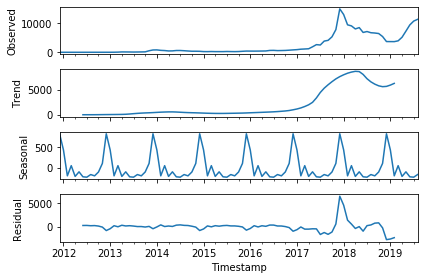

In [18]:
# define seasonal trend decomposition
from statsmodels.tsa.seasonal import seasonal_decompose

def decompose(series):
    plt.figure(figsize = (17,12))
    seasonal_decompose(series).plot()
    plt.show()

decompose(df_bitstamp_m.Weighted_Price)

### Price prediction

In [19]:
# change timeseries to daily
df_bitstamp = df_bitstamp.resample('D').mean()
df_bitstamp = df_bitstamp.reset_index()

In [20]:
# add a value day_diff to df_bitstamp *day_diff = (close price - open price) / open price
kwargs = { 'day_diff': lambda x: (x['Close']-x['Open'])/x['Open']}
df_bitstamp = df_bitstamp.assign(**kwargs)
df_bitstamp.head()

,Timestamp,Open,High,Low,Close,Volume_(BTC),Volume_(Currency),Weighted_Price,day_diff
0,2011-12-31,4.472552,4.472624,4.472552,4.472624,7.590527,34.069690,4.472579,0.000016
1,2012-01-01,4.680778,4.680778,4.680778,4.680778,5.861697,27.856539,4.680778,0.000000
2,2012-01-02,5.000000,5.000000,5.000000,5.000000,11.566478,57.832389,5.000000,0.000000
3,2012-01-03,5.145917,5.145917,5.145917,5.145917,13.506125,68.725391,5.145917,0.000000
4,2012-01-04,5.176708,5.228729,5.176708,5.228729,17.221039,91.624089,5.195443,0.010049


Stock prices are commonly treated as random walks, which can be defined in these mathematical terms:
$$\begin{align}
PredPrice_{t} &amp; = ActualPrice_{t-1} * \epsilon, \epsilon \sim N(\mu, \sigma)
\end{align}$$
We'll determine μ and σ from the training sets and apply the random walk model to the Bitcoin test sets.
<br>Data that follows random walks should be normally distributed. Therefore, first, to make sure the daily change in price follows a normal distribution, We'll plot the histogram of values.

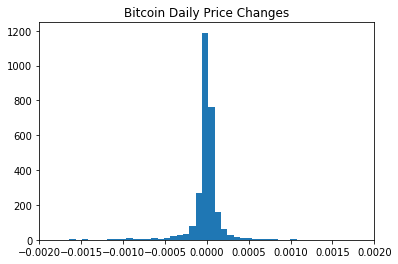

In [21]:
# We'll set a split date between train and test set to 2017-06-01
split_date = '2017-06-01'

fig, ax1 = plt.subplots(1,1)
ax1.hist(df_bitstamp['day_diff'].values, bins=300)
ax1.set_xlim([-0.002, 0.002])
ax1.set_title('Bitcoin Daily Price Changes')
plt.show()

In [22]:
split_date = '2017-06-01'
import datetime
np.random.seed(202)
bt_r_walk_mean, bt_r_walk_sd = (df_bitstamp[df_bitstamp['Timestamp']< split_date]['day_diff']).mean(), \
                         (df_bitstamp[df_bitstamp['Timestamp']< split_date]['day_diff']).std()
bt_random_steps = np.random.normal(loc = bt_r_walk_mean, scale = bt_r_walk_sd, 
                size = (max(df_bitstamp['Timestamp']).to_pydatetime() - datetime.datetime.strptime(split_date, '%Y-%m-%d')).days + 1)

trace_0 = go.Scatter(x = df_bitstamp[df_bitstamp['Timestamp']>= split_date]['Timestamp'],
                   y = df_bitstamp[df_bitstamp['Timestamp']>= split_date]['Close'],
                   mode = "lines",
                   name = "Actual",
                   marker = dict(color = 'rgba(235, 115, 150, 0.5)')
                       )

trace_1 = go.Scatter(x = df_bitstamp[df_bitstamp['Timestamp']>= split_date]['Timestamp'],
                   y = df_bitstamp[(df_bitstamp['Timestamp']+ datetime.timedelta(days=1))>= split_date]['Close'].values[1:] * (1+bt_random_steps),
                   mode = "lines",
                   name = "Predict",
                   marker = dict(color = 'rgba(115, 120, 235, 0.5)')
                       )

data_3 = [trace_0, trace_1]
layout_3 = go.Layout(height=400, width=550,
                title='Random walk prediction', 
                xaxis_title="timestamp",
                yaxis_title="Price /USD", 
                     xaxis=dict(range=['2017-06-01', '2018-12-31']))

fig = dict(data = data_3, layout = layout_3)
iplot(fig);


The prediction line tracks very closely the actual price, since at each new time point, the value follows the true price and the random step is added for prediction. Meaning that errors aren't carried over to subsequent predictions, no matter how large the error is. 

The Bitcoin random walk is particularly deceptive, as the scale of the y-axis is quite wide, making the prediction line appear quite smooth.

### Long Short Term Memory (LSTM)
For the Bitcoin's price prediction, we're going to utilize a Long Short Term Memory (LSTM) model which is known to suit time-series data.(Theory behind LSTMs: [1](http://colah.github.io/posts/2015-08-Understanding-LSTMs/), [2](http://blog.echen.me/2017/05/30/exploring-lstms/), [3](http://www.bioinf.jku.at/publications/older/2604.pdf))
Our LSTM model will use previous data to predict the next day's closing price.
<br>We'll create a new dataframe called model_data.
<br>The close_off_high represents the gap between the closing price and price high for that day. When High price equals to Close price, the value is -1. When Close price equals to Low price, the value is 1. 
<br>The volatility columns are simply the difference between high and low price divided by the opening price. 

In [23]:
# add close_off_high, bt_volatility
kwargs = {'close_off_high': lambda x: 2*(x['High']- x['Close'])/(x['High']-x['Low'])-1,
          'volatility': lambda x: (x['High']- x['Low'])/(x['Open'])}
model_data = df_bitstamp.assign(**kwargs)

In [24]:
# re-order model_data by the timestamp
model_data = model_data.sort_values(by='Timestamp')

Remove open price, Timestamp, Volume_(Currency), daily highs and lows.

In [25]:
# drop columns
model_data = model_data[['Timestamp','Close','Volume_(BTC)','close_off_high','volatility']]

In [26]:
# drop all the nulls model_data the data frame 
# (LSTM model would not work if there is null in the data)
model_data.dropna(inplace=True)

In [27]:
# split data frame to training/test data　
training_set, test_set = model_data[model_data['Timestamp']<split_date], model_data[model_data['Timestamp']>=split_date]
training_set = training_set.drop('Timestamp', axis=1)
test_set = test_set.drop('Timestamp', axis=1)

Since the dataset is arranged in order of earliest to latest. The timestamp column is not needed anymore. 

We must decide how many previous days it will have access to. We'll use 10 days, as it's a nice round number. We build little data frames consisting of 10 consecutive days of data (called windows), so the first window will consist of the 0-9th rows of the training set (Python is zero-indexed), the second will be the rows 1-10, etc. Picking a small window size means we can feed more windows into our model.

Deep learning models don't like inputs that vary wildly. Typically, you want values between -1 and 1. We'll normalise the inputs to the first value in the window.

In [28]:
# normalization of 'Close','Volume_(BTC)'
window_len = 10
norm_cols = [['Close','Volume_(BTC)']]
LSTM_training_inputs = []
for i in range(len(training_set)-window_len):
    temp_set = training_set[i:(i+window_len)].copy()
    for col in norm_cols:
        # deviding all the values in the columns by the value of the first row
        temp_set.loc[:, col] = temp_set[col]/temp_set[col].iloc[0] - 1
    LSTM_training_inputs.append(temp_set)
LSTM_training_outputs = (training_set['Close'][window_len:].values/training_set['Close'][:-window_len].values)-1

In [29]:
LSTM_test_inputs = []
for i in range(len(test_set)-window_len):
    temp_set = test_set[i:(i+window_len)].copy()
    for col in norm_cols:
        temp_set.loc[:, col] = temp_set[col]/temp_set[col].iloc[0] - 1 
    LSTM_test_inputs.append(temp_set)
LSTM_test_outputs = (test_set['Close'][window_len:].values/test_set['Close'][:-window_len].values)-1

In [30]:
LSTM_training_inputs[0]

,Close,Volume_(BTC),close_off_high,volatility
0,0.000000,0.000000,-1.000000,0.000016
4,0.169052,1.268754,-1.000000,0.010049
5,0.371659,-0.167266,-1.000000,0.002965
6,0.464819,-0.512264,-1.000000,0.003141
9,0.494732,-0.631366,1.000000,0.004134
11,0.566810,-0.510114,-1.000000,0.000403
13,0.513384,-0.869066,-0.591148,0.002740
14,0.429561,-0.804193,1.000000,0.012580
17,0.545032,-0.540842,1.000000,0.000030
18,0.465353,-0.263106,-0.985697,0.003568


This table represents an example of our LSTM model input. The next table contains the next 10 days's dataset, meaning that it's single timepoint prediction. 
<br>We're now ready to build the LSTM model. This is actually quite straightforward with Keras, you simply stack componenets on top of each other. 

For LSTMs with Keras, I refered to several articles [1](https://qiita.com/yukiB/items/5d5b202af86e3c587843), [2](https://qiita.com/yuyakato/items/ab38064ca215e8750865). (both written in Japanese).

In [31]:
# Work with numpy arraysespecially as we now only have numerical data
LSTM_training_inputs = [np.array(LSTM_training_input) for LSTM_training_input in LSTM_training_inputs]
LSTM_training_inputs = np.array(LSTM_training_inputs)
LSTM_test_inputs = [np.array(LSTM_test_inputs) for LSTM_test_inputs in LSTM_test_inputs]
LSTM_test_inputs = np.array(LSTM_test_inputs)

In [32]:
# import the relevant Keras modules
from keras.models import Sequential
from keras.layers import Activation, Dense
from keras.layers import LSTM
from keras.layers import Dropout

def build_model(inputs, output_size, neurons, activ_func="linear",
                dropout=0.25, loss="mae", optimizer="adam"):
    model = Sequential()

    model.add(LSTM(neurons, input_shape=(inputs.shape[1], inputs.shape[2])))
    model.add(Dropout(dropout))
    model.add(Dense(units=output_size))
    model.add(Activation(activ_func))

    model.compile(loss=loss, optimizer=optimizer)
    return model

Using TensorFlow backend.


So, the build_model functions constructs an empty model called "model" (model = Sequential), to which an LSTM layer is added. That layer has been shaped to fit our inputs (n x m tables, where n and m represent the number of timepoints/rows and columns, respectively). The function also includes more generic neural network features, like [dropout](https://machinelearningmastery.com/dropout-regularization-deep-learning-models-keras/) and [activation functions](https://dashee87.github.io/deep%20learning/visualising-activation-functions-in-neural-networks/). Now, we just need to specify the number of neurons to place in the LSTM layer (I've opted for 20 to keep runtime reasonable), as well as the data on which the model will be trained.

In [33]:
# random seed for reproducibility
np.random.seed(202)
bit_model = build_model(LSTM_training_inputs, output_size=1, neurons = 20)
# model output is next price normalised to 10th previous closing price
LSTM_training_outputs = (training_set['Close'][window_len:].values/training_set['Close'][:-window_len].values)-1
# train model on data
# note: bit_history contains information on the training error per epoch
bit_history = bit_model.fit(LSTM_training_inputs, LSTM_training_outputs, 
                            epochs=50, batch_size=1, verbose=2, shuffle=True)

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Use tf.cast instead.
Epoch 1/50
 - 12s - loss: 0.0610
Epoch 2/50
 - 12s - loss: 0.0405
Epoch 3/50
 - 12s - loss: 0.0363
Epoch 4/50
 - 12s - loss: 0.0337
Epoch 5/50
 - 12s - loss: 0.0316
Epoch 6/50
 - 12s - loss: 0.0300
Epoch 7/50
 - 11s - loss: 0.0308
Epoch 8/50
 - 12s - loss: 0.0301
Epoch 9/50
 - 12s - loss: 0.0295
Epoch 10/50
 - 12s - loss: 0.0302
Epoch 11/50
 - 12s - loss: 0.0287
Epoch 12/50
 - 12s - loss: 0.0280
Epoch 13/50
 - 12s - loss: 0.0283
Epoch 14/50
 - 11s - loss: 0.0289
Epoch 15/50
 - 12s - loss: 0.0286
Epoch 16/50
 - 12s - loss: 0.0279
Epoch 17/50
 - 12s - loss: 0.0277
Epoch 18/50
 - 12s - loss: 0.0293
Epoch 19/50
 - 12s - loss: 0.0279
Epoch 20/50
 - 12s - loss: 0.0279
Epoch 21/50
 - 12s - loss: 0.0275
Epoch 22/50
 - 12s - loss: 0.0275
Epoch 23/50
 - 12s - loss: 0.0283
Epoch 24/50
 - 12s - loss: 0.0274
Epoch 25/50
 - 12s - loss: 0.0286
Epoch 26/50
 - 12s - loss: 0.0281
Epoch

If everything went to plan, then we'd expect the training error to have gradually decreased over time.

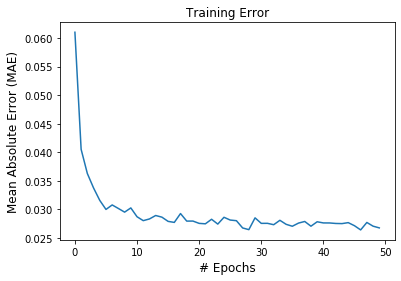

In [34]:
fig, ax1 = plt.subplots(1,1)

ax1.plot(bit_history.epoch, bit_history.history['loss'])
ax1.set_title('Training Error')

if bit_model.loss == 'mae':
    ax1.set_ylabel('Mean Absolute Error (MAE)',fontsize=12)
# just in case you decided to change the model loss calculation
else:
    ax1.set_ylabel('Model Loss',fontsize=12)
ax1.set_xlabel('# Epochs',fontsize=12)
plt.show()

See how well this modeel performs on testset. That number below the code represents the model's mean absolute error (mae) on the training set after the 50th training iteration (or epoch).

In [35]:
trace_ac = go.Scatter(x = model_data[model_data['Timestamp']>= split_date]['Timestamp'][window_len:],
                   y = test_set['Close'][window_len:],
                   mode = "lines",
                   name = "Actual",
                   marker = dict(color = 'rgba(235, 115, 150, 0.5)')
                       )

trace_pre = go.Scatter(x = model_data[model_data['Timestamp']>= split_date]['Timestamp'][window_len:],
                   y = ((np.transpose(bit_model.predict(LSTM_test_inputs))+1) * test_set['Close'].values[:-window_len])[0],
                   mode = "lines",
                   name = "Predicted",
                   marker = dict(color = 'rgba(115, 120, 235, 0.5)')
                      )
            
data_3 = [trace_ac, trace_pre]

layout_3 = go.Layout(height=400, width=550,
                title='Test Set: Single Timepoint Prediction', 
                xaxis_title="timestamp",
                yaxis_title="Price /USD", 
                     xaxis=dict(range=['2017-06-01', '2018-12-31']))

fig = dict(data = data_3, layout = layout_3)


iplot(fig);

Single point predictions can be deceptive, as we saw in the random walk prediction. Looking more closely, you'll notice that, again, the predicted values regularly mirror the previous values (e.g. October). 
<br>LSTM model has partially reproducted a autregressive (AR) model of some order p, where future values are simply the weighted sum of the previous p values. We can define an AR model in these mathematical terms:
$$\begin{align}
PredPrice_{t} &amp; = \phi_0 + \phi_1*Price_{t-1} + \ldots + \phi_p*Price_{t-p} + \epsilon_t, \ \epsilon_t \sim N(0, \sigma)\
\end{align}$$
The good news is that AR models are commonly employed in time series tasks (e.g. stock market prices), so the LSTM model appears to have landed on a sensible solution. The bad news is that it's a waste of the LSTM capabilities, we could have a built a much simpler AR model in much less time and probably achieved similar results.([More complex does not automatically equal more accurate](https://pdfs.semanticscholar.org/696c/2fa5697f58914921ff37d69ced44ddea143f.pdf)).

We'll now build LSTM models to predict crypto prices for the next 5 days.

In [36]:
# random seed for reproducibility
np.random.seed(202)

# we'll try to predict the closing price for the next 5 days
# change this value if you want to make longer/shorter prediction
pred_range = 5

# initialise model architecture
bit_model = build_model(LSTM_training_inputs, output_size=pred_range, neurons = 20)

# model output is next 5 prices normalised to 10th previous closing price
LSTM_training_outputs = []
for i in range(window_len, len(training_set['Close'])-pred_range):
    LSTM_training_outputs.append((training_set['Close'][i:i+pred_range].values/
                                  training_set['Close'].values[i-window_len])-1)
LSTM_training_outputs = np.array(LSTM_training_outputs)

# train model on data (same as single point prediction)
# note: bit_history contains information on the training error per epoch
bit_history = bit_model.fit(LSTM_training_inputs[:-pred_range], LSTM_training_outputs, 
                            epochs=50, batch_size=1, verbose=2, shuffle=True)

Epoch 1/50
 - 12s - loss: 0.0814
Epoch 2/50
 - 12s - loss: 0.0613
Epoch 3/50
 - 11s - loss: 0.0570
Epoch 4/50
 - 12s - loss: 0.0541
Epoch 5/50
 - 12s - loss: 0.0542
Epoch 6/50
 - 12s - loss: 0.0532
Epoch 7/50
 - 12s - loss: 0.0543
Epoch 8/50
 - 12s - loss: 0.0527
Epoch 9/50
 - 12s - loss: 0.0531
Epoch 10/50
 - 12s - loss: 0.0524
Epoch 11/50
 - 12s - loss: 0.0522
Epoch 12/50
 - 12s - loss: 0.0519
Epoch 13/50
 - 12s - loss: 0.0524
Epoch 14/50
 - 18s - loss: 0.0526
Epoch 15/50
 - 12s - loss: 0.0521
Epoch 16/50
 - 12s - loss: 0.0514
Epoch 17/50
 - 14s - loss: 0.0515
Epoch 18/50
 - 12s - loss: 0.0516
Epoch 19/50
 - 12s - loss: 0.0507
Epoch 20/50
 - 17s - loss: 0.0520
Epoch 21/50
 - 13s - loss: 0.0514
Epoch 22/50
 - 13s - loss: 0.0514
Epoch 23/50
 - 14s - loss: 0.0513
Epoch 24/50
 - 14s - loss: 0.0520
Epoch 25/50
 - 13s - loss: 0.0521
Epoch 26/50
 - 13s - loss: 0.0509
Epoch 27/50
 - 15s - loss: 0.0510
Epoch 28/50
 - 16s - loss: 0.0504
Epoch 29/50
 - 16s - loss: 0.0512
Epoch 30/50
 - 14s - lo

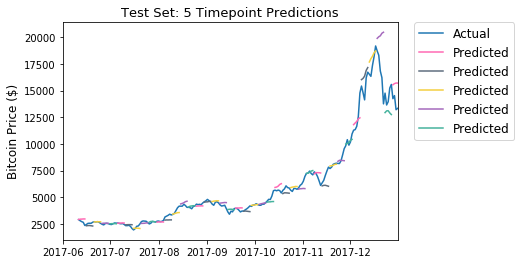

In [37]:
# little bit of reformatting the predictions to closing prices
bt_pred_prices = ((bit_model.predict(LSTM_test_inputs)[:-pred_range][::pred_range]+1)*\
                   test_set['Close'].values[:-(window_len + pred_range)][::5].reshape(int(np.ceil((len(LSTM_test_inputs)-pred_range)/float(pred_range))),1))

pred_colors = ["#FF69B4", "#5D6D7E", "#F4D03F","#A569BD","#45B39D"]
fig, ax1 = plt.subplots(1,1)
ax1.plot(model_data[model_data['Timestamp']>= split_date]['Timestamp'][window_len:],
         test_set['Close'][window_len:], label='Actual')

for i, (bt_pred) in enumerate(bt_pred_prices):
    # Only adding lines to the legend once
    if i<5:
        ax1.plot(model_data[model_data['Timestamp']>= split_date]['Timestamp'][window_len:][i*pred_range:i*pred_range+pred_range],
                 bt_pred, color=pred_colors[i%5], label="Predicted")
    else: 
        ax1.plot(model_data[model_data['Timestamp']>= split_date]['Timestamp'][window_len:][i*pred_range:i*pred_range+pred_range],
                 bt_pred, color=pred_colors[i%5])

ax1.set_title('Test Set: 5 Timepoint Predictions',fontsize=13)
ax1.set_ylabel('Bitcoin Price ($)',fontsize=12)
ax1.set_xlim('2017-06-01', '2017-12-31')
ax1.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0., prop={'size': 12})

plt.show()

The predictions are visibly less impressive than their single point counterparts. Nevertheless, the model returned somewhat nuanced behaviours. It didn't simply forecast prices to move uniformly in one direction. So there are some grounds for optimism.

Moving back to the single point predictions, our deep machine artificial neural model looks okay, but so did that boring random walk model. Like the random walk model, LSTM models can be sensitive to the choice of random seed (the model weights are initially randomly assigned).